## use it in PyTorch

In [1]:
%matplotlib inline
# data_dir = "data"
data_dir = "lexicalized_data"

from dataset import syntax_token_type
syntax_vocabulary, blacklist = syntax_token_type(data_dir)

encountering ambiguous tag at lexicalized_data/sw2260#s283_500/syntax.txt, break-tied
encountering type II typo at lexicalized_data/sw2249#s67_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2789#s226_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2229#s140_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2589#s154_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2067#s50_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2154#s6_500/syntax.txt, blacklisted
encountering ambiguous tag at lexicalized_data/sw2015#s53_500/syntax.txt, break-tied
encountering type II typo at lexicalized_data/sw2079#s10_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2434#s87_500/syntax.txt, blacklisted
encountering a weird semicolon at lexicalized_data/sw3049#s167_500/syntax.txt, blacklisted
encountering type II typo at lexicalized_data/sw2229#s23

In [2]:
if data_dir == "data":
    print(syntax_vocabulary)
print(len(syntax_vocabulary))
print(blacklist)

13812
{'lexicalized_data/sw2719#s157_500', 'lexicalized_data/sw2249#s67_500', 'lexicalized_data/sw2789#s226_500', 'lexicalized_data/sw2249#s148_500', 'lexicalized_data/sw3561#s32_500', 'lexicalized_data/sw2589#s154_500', 'lexicalized_data/sw3294#s121_500', 'lexicalized_data/sw2078#s154_500', 'lexicalized_data/sw2249#s194_500', 'lexicalized_data/sw2154#s93_500', 'lexicalized_data/sw2229#s91_500', 'lexicalized_data/sw2154#s6_500', 'lexicalized_data/sw2229#s140_500', 'lexicalized_data/sw2434#s87_500', 'lexicalized_data/sw2249#s149_500', 'lexicalized_data/sw2229#s232_500', 'lexicalized_data/sw2067#s50_500', 'lexicalized_data/sw3049#s167_500', 'lexicalized_data/sw2784#s85_500', 'lexicalized_data/sw2641#s78_500', 'lexicalized_data/sw2079#s10_500'}


In [3]:
from dataset import Phase, get_dataloader

dataloader = get_dataloader(
    root=data_dir, phase=Phase.TRAIN, syntax_vocabulary=syntax_vocabulary, blacklist=blacklist,
    batch_size=4, shuffle=True, num_workers=2,
    return_original=True  # we want the raw audio returned as well
)

This is only for demo. You probably will never call ```pad_packed_sequence``` explicitly, which wastes a good deal of memory

In [4]:
from torch.nn.utils.rnn import PackedSequence, pad_packed_sequence
from dataset import restore_order
import numpy as np

for speech, mfcc, syntax in dataloader:
    speech, inv_perm_index_speech = speech
    mfcc, inv_perm_index_mfcc = mfcc
    syntax, inv_perm_index_syntax = syntax
    assert type(speech) == PackedSequence
    assert type(mfcc) == PackedSequence
    assert type(syntax) == PackedSequence  # PackedSequence can be fed into a RNN directly
    
    # okay let's pretend there's a RNN and we are through it
    unpacked_speech, unpacked_speech_len = pad_packed_sequence(speech, batch_first=True)
    # restore order
    unpacked_speech = restore_order(unpacked_speech, inv_perm_index_speech)
    unpacked_speech_len = np.take(unpacked_speech_len, inv_perm_index_speech)
    print("speech batch")
    print(unpacked_speech.shape)
    print(unpacked_speech_len)
    
    unpacked_mfcc, unpacked_mfcc_len = pad_packed_sequence(mfcc, batch_first=True)
    # restore order
    unpacked_mfcc = restore_order(unpacked_mfcc, inv_perm_index_mfcc)
    unpacked_mfcc_len = np.take(unpacked_mfcc_len, inv_perm_index_mfcc)
    print("mfcc batch")
    print(unpacked_mfcc.shape)
    print(unpacked_mfcc_len)
    
    unpacked_syntax, unpacked_syntax_len = pad_packed_sequence(syntax, batch_first=True)
    # restore order
    unpacked_syntax = restore_order(unpacked_syntax, inv_perm_index_syntax)
    unpacked_syntax_len = np.take(unpacked_syntax_len, inv_perm_index_syntax)
    print("syntax batch")
    print(unpacked_syntax.shape)
    print(unpacked_syntax_len)
    
    print("It's only a demo, people.")
    break

speech batch
torch.Size([4, 39480])
tensor([ 2240, 14197, 39480, 13390])
mfcc batch
torch.Size([4, 494, 13])
tensor([ 29, 178, 494, 168])
syntax batch
torch.Size([4, 126])
tensor([  9,  60, 126,  42])
It's only a demo, people.


In [5]:
import IPython
import IPython.display as ipd
from nltk.tree import Tree
import librosa.display
import matplotlib.pyplot as plt


def display_speech(unpacked_speech, unpacked_speech_len):
    auds = []
    speeches = []
    for s, l in zip(unpacked_speech, unpacked_speech_len):
        speech = s[:l].numpy()
        speeches.append(speech)
        auds.append(ipd.Audio(speech, rate=8000))
    return auds, speeches


def display_mfcc(unpacked_mfcc, unpacked_mfcc_len):
    mfccs = []
    for s, l in zip(unpacked_mfcc, unpacked_mfcc_len):
        mfcc = s[:l].numpy().T  # [n_mfcc, t]
        mfccs.append(mfcc)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc, hop_length=80, sr=8000, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        plt.tight_layout()
        plt.show()
    return mfccs


def display_syntax(unpacked_syntax, unpacked_syntax_len):
    for s, l in zip(unpacked_syntax, unpacked_syntax_len):
        indices = s[:l].numpy()
        tokens = []
        for i in indices:  # turn indices into human-readable strings
            for k, v in syntax_vocabulary.items():
                if v == i:
                    tokens.append(k)
                    break
        syntax = "".join(tokens)
        print(syntax)
        tree = Tree.fromstring(syntax, brackets="[]")
        IPython.core.display.display(tree)


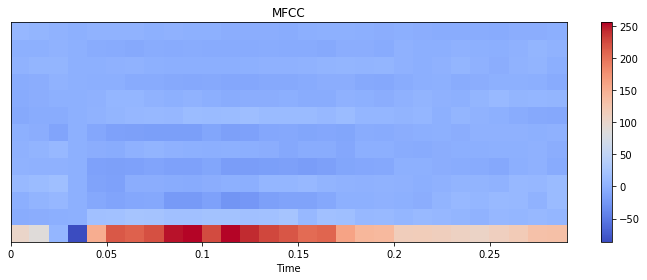

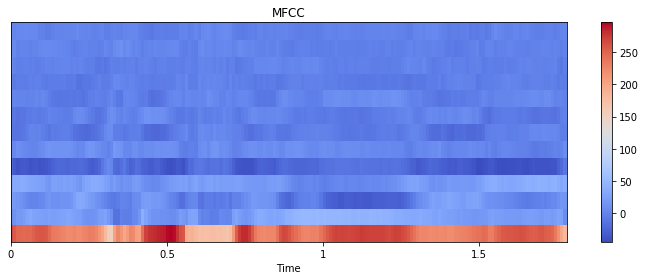

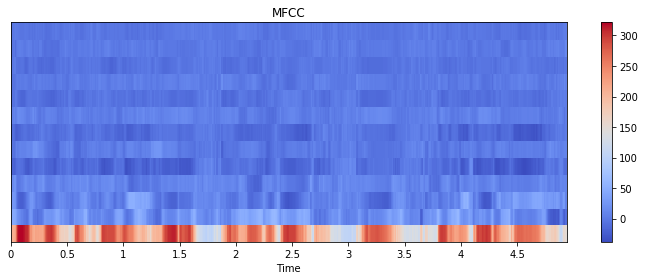

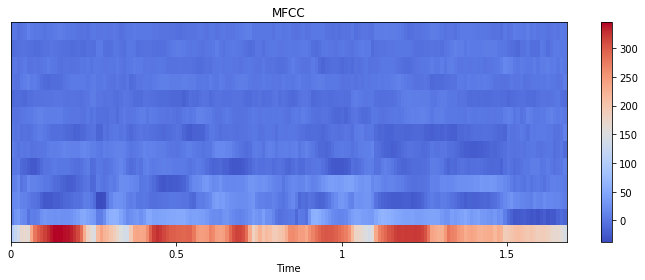

In [6]:
auds, speeches = display_speech(unpacked_speech, unpacked_speech_len)
mfccs = display_mfcc(unpacked_mfcc, unpacked_mfcc_len)

[S[CC[But]]]


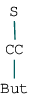

[S[CC[and]][NP[PRP[you]]][VP[MD[ca]][RB[n't]][VP[VB[sing]][ADVP[IN[along]]][ADVP[CC[either]]]]]]


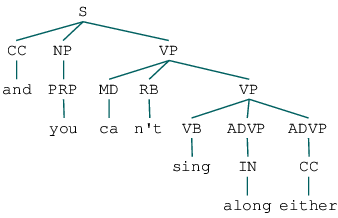

[S[NP[NP[PRP$[my]][NN[husband]][POS['s]]][NN[family]]][VP[VBD[had]][EDITED[NP[DT[a]]]][NP[DT[a]][NN[motor]][NN[boat]]][INTJ[UH[uh]]][SBAR[WHADVP[WRB[when]]][S[NP[PRP[we]]][VP[VBD[got]][VP[JJ[engaged]]]]]]]]


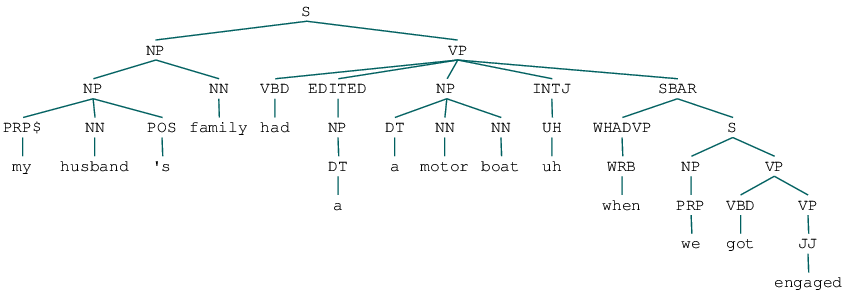

[S[NP[NNP[Al]][NNP[Capone]]][VP[VBD[had]][NP[CD[three]][NNS[brothers]]]]]


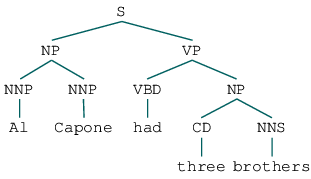

In [7]:
display_syntax(unpacked_syntax, unpacked_syntax_len)

In [8]:
auds[0]

In [9]:
auds[1]

In [10]:
auds[2]

In [11]:
auds[3]

### reconstruct waveform from mfcc

In [12]:
n_mels = 26
n_mfcc = 13
n_fft = 256
hop_length = 80
sr = 8000

In [13]:
# CREDIT: https://github.com/librosa/librosa/issues/424
import librosa
from logmmse import logmmse


def invlogamplitude(S):
    return 10.0**(S/10.0)


def reconstruct(mfcc, aud):
    dct = librosa.filters.dct(n_filters=n_mfcc, n_input=n_mels)
    mel_basis = librosa.filters.mel(n_mels=n_mels, n_fft=n_fft, sr=8000)
    bin_scaling = 1.0/np.maximum(0.0001, np.sum(np.dot(mel_basis.T, mel_basis),axis=0))
    recon_stft = bin_scaling[:, np.newaxis] * np.dot(mel_basis.T, invlogamplitude(np.dot(dct.T, mfcc)))
    excitation = np.random.randn(aud.shape[0])
    E = librosa.stft(excitation, n_fft=n_fft, hop_length=hop_length)
    recon = librosa.istft(E/np.abs(E)*np.sqrt(recon_stft), hop_length=hop_length, win_length=n_fft)
    plt.figure(figsize=(10, 4))
    plt.subplot(211)
    librosa.display.waveplot(aud.astype(np.float), sr=sr)
    plt.subplot(212)
    librosa.display.waveplot(recon, sr=sr)
    plt.show()
    return ipd.Audio(recon, rate=sr)


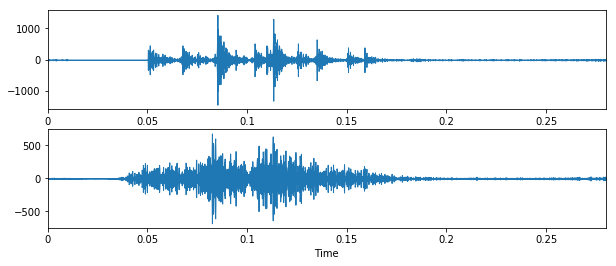

In [14]:
reconstruct(mfccs[0], speeches[0])

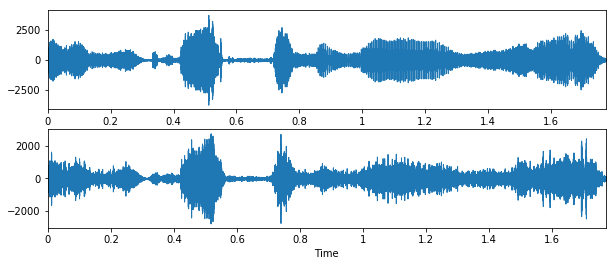

In [15]:
reconstruct(mfccs[1], speeches[1])

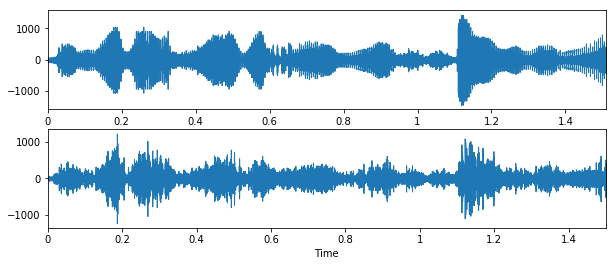

In [31]:
reconstruct(mfccs[2], speeches[2])

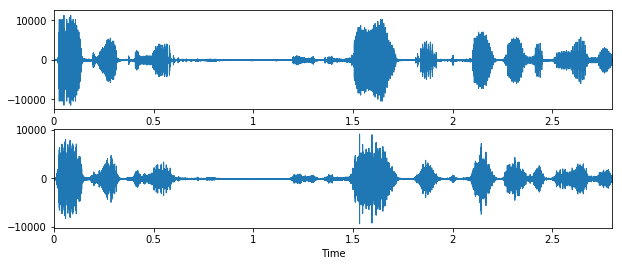

In [32]:
reconstruct(mfccs[3], speeches[3])